## Problem Statement

You need to build a model that is able to classify customer complaints based on the products/services. By doing so, you can segregate these tickets into their relevant categories and, therefore, help in the quick resolution of the issue.

You will be doing topic modelling on the <b>.json</b> data provided by the company. Since this data is not labelled, you need to apply NMF to analyse patterns and classify tickets into the following five clusters based on their products/services:

* Credit card / Prepaid card

* Bank account services

* Theft/Dispute reporting

* Mortgages/loans

* Others


With the help of topic modelling, you will be able to map each ticket onto its respective department/category. You can then use this data to train any supervised model such as logistic regression, decision tree or random forest. Using this trained model, you can classify any new customer complaint support ticket into its relevant department.

## Pipelines that needs to be performed:

You need to perform the following eight major tasks to complete the assignment:

1.  Data loading

2. Text preprocessing

3. Exploratory data analysis (EDA)

4. Feature extraction

5. Topic modelling

6. Model building using supervised learning

7. Model training and evaluation

8. Model inference

## Importing the necessary libraries

In [78]:
import json
import numpy as np
import pandas as pd
import re, nltk, spacy, string
import en_core_web_sm
nlp = en_core_web_sm.load()
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from pprint import pprint

## Loading the data

The data is in JSON format and we need to convert it to a dataframe.

In [79]:
from google.colab import drive
def mount_drive():
  drive.mount('/content/gdrive')


In [80]:
# Opening JSON file
f = '/content/gdrive/My Drive/Upgrad-EPGP-AIML/workspace/topic_modeling/complaints-2021-05-14_08_16.json' # Write the path to your data file and load it
mount_drive()

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [81]:
# returns JSON object as
# a dictionary
with open(f, 'r') as file:
  data = json.load(file)
  df = pd.json_normalize(data)

In [82]:
df.head()

,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,...,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


## Data preparation

In [83]:
print("Shape of the dataframe:", df.shape)

Shape of the dataframe: (78313, 22)


In [84]:
# Inspect the dataframe to understand the given data.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78313 entries, 0 to 78312
Data columns (total 22 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   _index                             78313 non-null  object 
 1   _type                              78313 non-null  object 
 2   _id                                78313 non-null  object 
 3   _score                             78313 non-null  float64
 4   _source.tags                       10900 non-null  object 
 5   _source.zip_code                   71556 non-null  object 
 6   _source.complaint_id               78313 non-null  object 
 7   _source.issue                      78313 non-null  object 
 8   _source.date_received              78313 non-null  object 
 9   _source.state                      76322 non-null  object 
 10  _source.consumer_disputed          78313 non-null  object 
 11  _source.product                    78313 non-null  obj

In [85]:
#print the column names
df.columns

Index(['_index', '_type', '_id', '_score', '_source.tags', '_source.zip_code',
       '_source.complaint_id', '_source.issue', '_source.date_received',
       '_source.state', '_source.consumer_disputed', '_source.product',
       '_source.company_response', '_source.company', '_source.submitted_via',
       '_source.date_sent_to_company', '_source.company_public_response',
       '_source.sub_product', '_source.timely',
       '_source.complaint_what_happened', '_source.sub_issue',
       '_source.consumer_consent_provided'],
      dtype='object')

In [86]:
#Assign new column names
df.columns = ['index', 'type', 'id', 'score', 'tags', 'zip_code',
       'complaint_id', 'issue', 'date_received',
       'state', 'consumer_disputed', 'product',
       'company_response', 'company', 'submitted_via',
       'date_sent_to_company', 'company_public_response',
       'sub_product', 'timely',
       'complaint_what_happened', 'sub_issue',
       'consumer_consent_provided']

In [87]:
df.head()

,index,type,id,score,tags,zip_code,complaint_id,issue,date_received,state,...,company_response,company,submitted_via,date_sent_to_company,company_public_response,sub_product,timely,complaint_what_happened,sub_issue,consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


In [88]:
len(df[df['complaint_what_happened'] == ''])

57241

In [89]:
#Assign nan in place of blanks in the complaints column
df.loc[df['complaint_what_happened'] == '', 'complaint_what_happened'] = np.nan

In [90]:
#Remove all rows where complaints column is nan
df.dropna(subset=['complaint_what_happened'], inplace=True)

In [91]:
df.head()

,index,type,id,score,tags,zip_code,complaint_id,issue,date_received,state,...,company_response,company,submitted_via,date_sent_to_company,company_public_response,sub_product,timely,complaint_what_happened,sub_issue,consumer_consent_provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
10,complaint-public-v2,complaint,3233499,0.0,None,104XX,3233499,Incorrect information on your report,2019-05-06T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-06T12:00:00-05:00,None,Other personal consumer report,Yes,Chase Card was reported on XX/XX/2019. However...,Information belongs to someone else,Consent provided
11,complaint-public-v2,complaint,3180294,0.0,None,750XX,3180294,Incorrect information on your report,2019-03-14T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-03-15T12:00:00-05:00,None,Credit reporting,Yes,"On XX/XX/2018, while trying to book a XXXX XX...",Information belongs to someone else,Consent provided
14,complaint-public-v2,complaint,3224980,0.0,None,920XX,3224980,Managing an account,2019-04-27T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-27T12:00:00-05:00,None,Checking account,Yes,my grand son give me check for {$1600.00} i de...,Funds not handled or disbursed as instructed,Consent provided


In [92]:
df.shape

(21072, 22)

## Prepare the text for topic modeling

Once you have removed all the blank complaints, you need to:

* Make the text lowercase
* Remove text in square brackets
* Remove punctuation
* Remove words containing numbers


Once you have done these cleaning operations you need to perform the following:
* Lemmatize the texts
* Extract the POS tags of the lemmatized text and remove all the words which have tags other than NN[tag == "NN"].


In [93]:
# Write your function here to clean the text and remove all the unnecessary elements.
def clean_text(text):
  # Make the text lowercase
  text = text.lower()
  # Remove text in square brackets
  text = re.sub('\[.*?\]', '', text)
  # Remove punctuation
  text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
  # Remove words containing numbers
  text = re.sub('\w*\d\w*', '', text)
  return text

In [94]:
df['cleaned_complaint'] = df['complaint_what_happened'].apply(clean_text)
df[['complaint_what_happened', 'cleaned_complaint']].head()

,complaint_what_happened,cleaned_complaint
1,Good morning my name is XXXX XXXX and I apprec...,good morning my name is xxxx xxxx and i apprec...
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,i upgraded my xxxx xxxx card in and was told ...
10,Chase Card was reported on XX/XX/2019. However...,chase card was reported on however fraudulent...
11,"On XX/XX/2018, while trying to book a XXXX XX...",on while trying to book a xxxx xxxx ticket ...
14,my grand son give me check for {$1600.00} i de...,my grand son give me check for i deposit it i...


In [95]:
#Write your function to Lemmatize the texts
def lemmatize_text(text):
  doc = nlp(text)
  lemmatized_text = " ".join([token.lemma_ for token in doc])
  return lemmatized_text

In [96]:
df['lemmatized_complaint'] = df['cleaned_complaint'].apply(lemmatize_text)
df[['cleaned_complaint', 'lemmatized_complaint']].head()

,cleaned_complaint,lemmatized_complaint
1,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...
2,i upgraded my xxxx xxxx card in and was told ...,I upgrade my xxxx xxxx card in and be tell b...
10,chase card was reported on however fraudulent...,chase card be report on however fraudulent a...
11,on while trying to book a xxxx xxxx ticket ...,on while try to book a xxxx xxxx ticket ...
14,my grand son give me check for i deposit it i...,my grand son give I check for I deposit it i...


In [309]:
#Create a dataframe('df_clean') that will have only the complaints and the lemmatized complaints
df_clean = df[['cleaned_complaint','lemmatized_complaint']]

In [310]:
df_clean

,cleaned_complaint,lemmatized_complaint
1,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...
2,i upgraded my xxxx xxxx card in and was told ...,I upgrade my xxxx xxxx card in and be tell b...
10,chase card was reported on however fraudulent...,chase card be report on however fraudulent a...
11,on while trying to book a xxxx xxxx ticket ...,on while try to book a xxxx xxxx ticket ...
14,my grand son give me check for i deposit it i...,my grand son give I check for I deposit it i...
...,...,...
78303,after being a chase card customer for well ove...,after be a chase card customer for well over a...
78309,on wednesday xxxxxxxx i called chas my xxxx xx...,on wednesday xxxxxxxx I call chas my xxxx xxxx...
78310,i am not familiar with xxxx pay and did not un...,I be not familiar with xxxx pay and do not und...
78311,i have had flawless credit for yrs ive had ch...,I have have flawless credit for yrs I ve hav...


In [311]:
#Write your function to extract the POS tags
def pos_tag(text):
  # write your code here
  doc = nlp(text)
  pos_tags = [token.text for token in doc if token.pos_ == "NOUN"] # Extracting NOUN tokens
  return " ".join(pos_tags)

df_clean["complaint_POS_removed"] = df_clean['lemmatized_complaint'].apply(pos_tag) #this column should contain lemmatized text with all the words removed which have tags other than NN[tag == "NN"].


<ipython-input-311-057a12b30fa7>:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [312]:
#The clean dataframe should now contain the raw complaint, lemmatized complaint and the complaint after removing POS tags.
df_clean

,cleaned_complaint,lemmatized_complaint,complaint_POS_removed
1,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop service debt verification st...
2,i upgraded my xxxx xxxx card in and was told ...,I upgrade my xxxx xxxx card in and be tell b...,card agent anniversary date agent information ...
10,chase card was reported on however fraudulent...,chase card be report on however fraudulent a...,chase card report application identity consent...
11,on while trying to book a xxxx xxxx ticket ...,on while try to book a xxxx xxxx ticket ...,ticket offer ticket reward card information of...
14,my grand son give me check for i deposit it i...,my grand son give I check for I deposit it i...,son chase account fund chase bank account mone...
...,...,...,...
78303,after being a chase card customer for well ove...,after be a chase card customer for well over a...,chase card customer decade solicitation credit...
78309,on wednesday xxxxxxxx i called chas my xxxx xx...,on wednesday xxxxxxxx I call chas my xxxx xxxx...,credit card provider claim purchase protection...
78310,i am not familiar with xxxx pay and did not un...,I be not familiar with xxxx pay and do not und...,pay risk consumer chase bank app chase year ba...
78311,i have had flawless credit for yrs ive had ch...,I have have flawless credit for yrs I ve hav...,credit yrs chase credit card chase freedom pro...


## Exploratory data analysis to get familiar with the data.

Write the code in this task to perform the following:

*   Visualise the data according to the 'Complaint' character length
*   Using a word cloud find the top 40 words by frequency among all the articles after processing the text
*   Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text. ‘




In [313]:
# Write your code here to visualise the data according to the 'Complaint' character length
df_clean['Complaint_length'] = df_clean['complaint_POS_removed'].apply(lambda x: len(x))

<ipython-input-313-0cc396b00b71>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



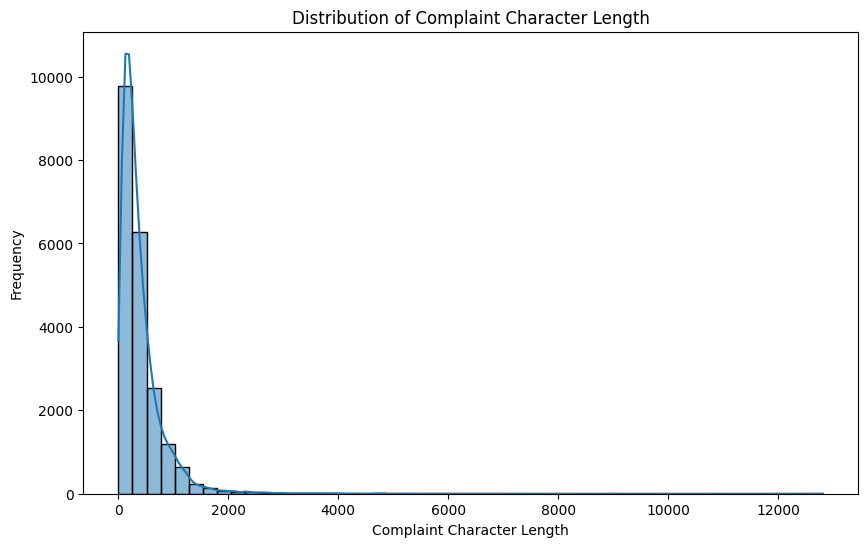

In [314]:
plt.figure(figsize=(10, 6))
sns.histplot(df_clean['Complaint_length'], bins=50, kde=True)
plt.title('Distribution of Complaint Character Length')
plt.xlabel('Complaint Character Length')
plt.ylabel('Frequency')
plt.show()

#### Find the top 40 words by frequency among all the articles after processing the text.

In [315]:
!pip install wordcloud
from wordcloud import WordCloud

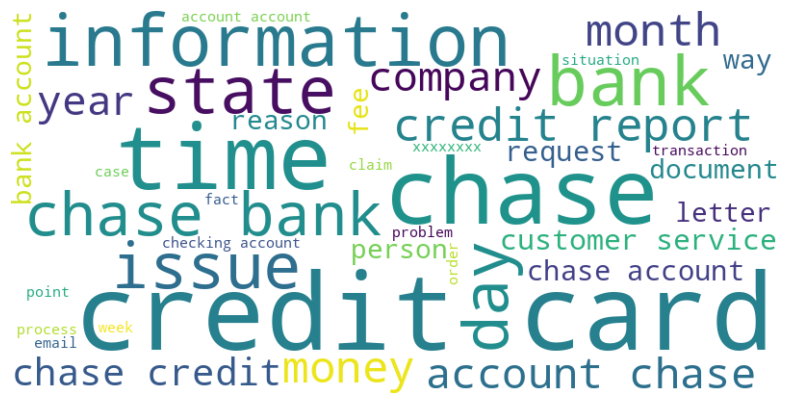

In [316]:
#Using a word cloud find the top 40 words by frequency among all the articles after processing the text

all_complaints = " ".join(df_clean['complaint_POS_removed'])

# Create a WordCloud object
wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=40).generate(all_complaints)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [317]:
#Removing -PRON- from the text corpus
df_clean['Complaint_clean'] = df_clean['complaint_POS_removed'].str.replace('-PRON-', '')

<ipython-input-317-2ee47e6ecbae>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



#### Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text.

In [318]:
#Write your code here to find the top 30 unigram frequency among the complaints in the cleaned datafram(df_clean).
def get_top_n_ngrams(corpus, n=None, ngram=1):
  vec = CountVectorizer(stop_words='english', ngram_range=(ngram, ngram)).fit(corpus)
  bag_of_words = vec.transform(corpus)
  sum_words = bag_of_words.sum(axis=0)
  words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
  words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
  return words_freq[:n]

In [319]:
# Get top 30 unigrams
top_unigrams = get_top_n_ngrams(df_clean['Complaint_clean'], n=30, ngram=1)

# Print the top unigrams
print("Top 30 Unigrams:")
for word, freq in top_unigrams:
  print(f"{word}: {freq}")

Top 30 Unigrams:
chase: 60052
account: 47223
credit: 33486
card: 30264
bank: 21611
payment: 21152
time: 16007
charge: 14740
day: 12936
money: 11929
check: 11574
loan: 10818
information: 9638
letter: 9589
fee: 8848
report: 8768
transaction: 8593
number: 8580
month: 8457
year: 8285
customer: 8126
mortgage: 7985
balance: 7753
service: 7711
phone: 7582
company: 7546
claim: 7278
fund: 7030
state: 6719
fraud: 6586


In [320]:
#Print the top 10 words in the unigram frequency
print("\nTop 10 Unigrams:")
for word, freq in top_unigrams[:10]:
    print(f"{word}: {freq}")


Top 10 Unigrams:
chase: 60052
account: 47223
credit: 33486
card: 30264
bank: 21611
payment: 21152
time: 16007
charge: 14740
day: 12936
money: 11929


In [321]:
#Write your code here to find the top 30 bigram frequency among the complaints in the cleaned datafram(df_clean).
top_bigrams = get_top_n_ngrams(df_clean['Complaint_clean'], n=30, ngram=2)
print("\nTop 30 Bigrams:")
for word, freq in top_bigrams:
  print(f"{word}: {freq}")


Top 30 Bigrams:
credit card: 12845
chase bank: 4003
credit report: 3948
account chase: 3557
chase credit: 3190
customer service: 3066
chase account: 2887
account account: 2492
bank account: 2472
checking account: 2415
debit card: 2001
chase card: 1830
card chase: 1808
check account: 1712
credit score: 1711
card account: 1704
account credit: 1538
payment payment: 1503
chase customer: 1343
money account: 1307
account bank: 1290
chase chase: 1266
phone number: 1263
business day: 1228
account number: 1150
charge account: 1148
payment chase: 1141
card company: 1135
charge chase: 1125
card card: 1102


In [322]:
#Print the top 10 words in the bigram frequency
print("\nTop 10 Bigrams:")
for word, freq in top_bigrams[:10]:
    print(f"{word}: {freq}")


Top 10 Bigrams:
credit card: 12845
chase bank: 4003
credit report: 3948
account chase: 3557
chase credit: 3190
customer service: 3066
chase account: 2887
account account: 2492
bank account: 2472
checking account: 2415


In [323]:
#Write your code here to find the top 30 trigram frequency among the complaints in the cleaned datafram(df_clean).
top_trigrams = get_top_n_ngrams(df_clean['Complaint_clean'], n=30, ngram=3)
print("\nTop 30 Trigrams:")
for word, freq in top_trigrams:
  print(f"{word}: {freq}")


Top 30 Trigrams:
chase credit card: 2161
credit card account: 1106
credit card company: 997
credit card chase: 836
chase customer service: 618
credit card credit: 529
inquiry credit report: 517
chase bank account: 436
account credit card: 435
charge credit card: 418
card credit card: 407
chase check account: 372
credit reporting agency: 370
credit report credit: 360
customer service representative: 348
credit reporting act: 338
credit card charge: 328
account chase bank: 316
credit card payment: 315
account chase account: 308
account credit report: 294
checking account chase: 286
credit card balance: 270
bank credit card: 268
credit report chase: 263
credit card card: 262
victim identity theft: 250
payment credit card: 239
credit card service: 230
freedom credit card: 229


In [324]:
#Print the top 10 words in the trigram frequency
print("\nTop 10 Trigrams:")
for word, freq in top_trigrams[:10]:
    print(f"{word}: {freq}")


Top 10 Trigrams:
chase credit card: 2161
credit card account: 1106
credit card company: 997
credit card chase: 836
chase customer service: 618
credit card credit: 529
inquiry credit report: 517
chase bank account: 436
account credit card: 435
charge credit card: 418


## The personal details of customer has been masked in the dataset with xxxx. Let's remove the masked text as this will be of no use for our analysis

In [325]:
df_clean['Complaint_clean'] = df_clean['Complaint_clean'].str.replace('xxxx','')

<ipython-input-325-d4beb8194a2f>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [326]:
#All masked texts has been removed
df_clean

,cleaned_complaint,lemmatized_complaint,complaint_POS_removed,Complaint_length,Complaint_clean
1,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop service debt verification st...,133,morning name stop service debt verification st...
2,i upgraded my xxxx xxxx card in and was told ...,I upgrade my xxxx xxxx card in and be tell b...,card agent anniversary date agent information ...,108,card agent anniversary date agent information ...
10,chase card was reported on however fraudulent...,chase card be report on however fraudulent a...,chase card report application identity consent...,80,chase card report application identity consent...
11,on while trying to book a xxxx xxxx ticket ...,on while try to book a xxxx xxxx ticket ...,ticket offer ticket reward card information of...,398,ticket offer ticket reward card information of...
14,my grand son give me check for i deposit it i...,my grand son give I check for I deposit it i...,son chase account fund chase bank account mone...,151,son chase account fund chase bank account mone...
...,...,...,...,...,...
78303,after being a chase card customer for well ove...,after be a chase card customer for well over a...,chase card customer decade solicitation credit...,215,chase card customer decade solicitation credit...
78309,on wednesday xxxxxxxx i called chas my xxxx xx...,on wednesday xxxxxxxx I call chas my xxxx xxxx...,credit card provider claim purchase protection...,642,credit card provider claim purchase protection...
78310,i am not familiar with xxxx pay and did not un...,I be not familiar with xxxx pay and do not und...,pay risk consumer chase bank app chase year ba...,697,pay risk consumer chase bank app chase year ba...
78311,i have had flawless credit for yrs ive had ch...,I have have flawless credit for yrs I ve hav...,credit yrs chase credit card chase freedom pro...,492,credit yrs chase credit card chase freedom pro...


## Feature Extraction
Convert the raw texts to a matrix of TF-IDF features

**max_df** is used for removing terms that appear too frequently, also known as "corpus-specific stop words"
max_df = 0.95 means "ignore terms that appear in more than 95% of the complaints"

**min_df** is used for removing terms that appear too infrequently
min_df = 2 means "ignore terms that appear in less than 2 complaints"

In [327]:
#Write your code here to initialise the TfidfVectorizer

tfidf = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')

#### Create a document term matrix using fit_transform

The contents of a document term matrix are tuples of (complaint_id,token_id) tf-idf score:
The tuples that are not there have a tf-idf score of 0

In [328]:
#Write your code here to create the Document Term Matrix by transforming the complaints column present in df_clean.
dtm = tfidf.fit_transform(df_clean['Complaint_clean'])

## Topic Modelling using NMF

Non-Negative Matrix Factorization (NMF) is an unsupervised technique so there are no labeling of topics that the model will be trained on. The way it works is that, NMF decomposes (or factorizes) high-dimensional vectors into a lower-dimensional representation. These lower-dimensional vectors are non-negative which also means their coefficients are non-negative.

In this task you have to perform the following:

* Find the best number of clusters
* Apply the best number to create word clusters
* Inspect & validate the correction of each cluster wrt the complaints
* Correct the labels if needed
* Map the clusters to topics/cluster names

In [329]:
from sklearn.decomposition import NMF

## Manual Topic Modeling
You need to do take the trial & error approach to find the best num of topics for your NMF model.

The only parameter that is required is the number of components i.e. the number of topics we want. This is the most crucial step in the whole topic modeling process and will greatly affect how good your final topics are.

In [330]:
#Load your nmf_model with the n_components i.e 5
num_topics = 5 #write the value you want to test out

#keep the random_state =40
nmf_model = NMF(n_components=num_topics, random_state=40) #write your code here

In [331]:
nmf_model.fit(dtm)

NMF(n_components=5, random_state=40)

In [332]:
len(tfidf.get_feature_names_out())

6858

In [333]:
#Print the Top15 words for each of the topics
for index, topic in enumerate(nmf_model.components_):
    print(f'Topic {index}')
    print([tfidf.get_feature_names_out()[i] for i in topic.argsort()[-15:]])

Topic 0
['customer', 'transfer', 'transaction', 'business', 'number', 'checking', 'day', 'branch', 'deposit', 'fund', 'chase', 'money', 'bank', 'check', 'account']
Topic 1
['reporting', 'year', 'letter', 'application', 'information', 'limit', 'debt', 'company', 'score', 'account', 'chase', 'inquiry', 'report', 'card', 'credit']
Topic 2
['request', 'sale', 'house', 'foreclosure', 'time', 'rate', 'document', 'letter', 'year', 'property', 'modification', 'home', 'chase', 'mortgage', 'loan']
Topic 3
['refund', 'email', 'statement', 'time', 'service', 'claim', 'fraud', 'merchant', 'purchase', 'dispute', 'transaction', 'fee', 'chase', 'card', 'charge']
Topic 4
['error', 'year', 'mortgage', 'account', 'credit', 'date', 'chase', 'auto', 'time', 'day', 'statement', 'fee', 'month', 'balance', 'payment']


In [334]:
#Create the best topic for each complaint in terms of integer value 0,1,2,3 & 4
topic_values = nmf_model.transform(dtm)
topic_values.argmax(axis=1)

array([2, 3, 1, ..., 3, 4, 4])

In [335]:
#Assign the best topic to each of the cmplaints in Topic Column
df_clean['Topic'] = topic_values.argmax(axis=1)#write your code to assign topics to each rows.
df_clean[['Complaint_clean','Topic']].head()

<ipython-input-335-bd6f9b66e6cf>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,Complaint_clean,Topic
1,morning name stop service debt verification st...,2
2,card agent anniversary date agent information ...,3
10,chase card report application identity consent...,1
11,ticket offer ticket reward card information of...,1
14,son chase account fund chase bank account mone...,0


In [336]:
df_clean.head()

,cleaned_complaint,lemmatized_complaint,complaint_POS_removed,Complaint_length,Complaint_clean,Topic
1,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop service debt verification st...,133,morning name stop service debt verification st...,2
2,i upgraded my xxxx xxxx card in and was told ...,I upgrade my xxxx xxxx card in and be tell b...,card agent anniversary date agent information ...,108,card agent anniversary date agent information ...,3
10,chase card was reported on however fraudulent...,chase card be report on however fraudulent a...,chase card report application identity consent...,80,chase card report application identity consent...,1
11,on while trying to book a xxxx xxxx ticket ...,on while try to book a xxxx xxxx ticket ...,ticket offer ticket reward card information of...,398,ticket offer ticket reward card information of...,1
14,my grand son give me check for i deposit it i...,my grand son give I check for I deposit it i...,son chase account fund chase bank account mone...,151,son chase account fund chase bank account mone...,0


In [337]:
#Print the first 5 Complaint for each of the Topics
df_clean_1=df_clean.groupby('Topic').head(5)
df_clean_1.sort_values('Topic')

,cleaned_complaint,lemmatized_complaint,complaint_POS_removed,Complaint_length,Complaint_clean,Topic
17,with out notice jp morgan chase restricted my ...,with out notice jp morgan chase restrict my ac...,notice jp account debit card branch customer s...,680,notice jp account debit card branch customer s...,0
14,my grand son give me check for i deposit it i...,my grand son give I check for I deposit it i...,son chase account fund chase bank account mone...,151,son chase account fund chase bank account mone...,0
27,i opened an account with chase bank on xxxx an...,I open an account with chase bank on xxxx and ...,account bank code bonus term account deposit b...,100,account bank code bonus term account deposit b...,0
24,mishandling of this account by chase auto and ...,mishandle of this account by chase auto and xxxx,mishandle account auto,22,mishandle account auto,0
35,i opened the saving account for the bonus i w...,I open the save account for the bonus I be s...,save account bonus bonus auto transfer check t...,136,save account bonus bonus auto transfer check t...,0
15,can you please remove inquiry,can you please remove inquiry,inquiry,7,inquiry,1
11,on while trying to book a xxxx xxxx ticket ...,on while try to book a xxxx xxxx ticket ...,ticket offer ticket reward card information of...,398,ticket offer ticket reward card information of...,1
10,chase card was reported on however fraudulent...,chase card be report on however fraudulent a...,chase card report application identity consent...,80,chase card report application identity consent...,1
26,i have reached out to xxxx several times in at...,I have reach out to xxxx several time in attem...,time attempt inquiry remove creditor inquiry r...,192,time attempt inquiry remove creditor inquiry r...,1
23,i have a chase credit card which is incorrectl...,I have a chase credit card which be incorrectl...,chase credit card report datum credit report c...,63,chase credit card report datum credit report c...,1


#### After evaluating the mapping, if the topics assigned are correct then assign these names to the relevant topic:
* Bank Account services
* Credit card or prepaid card
* Theft/Dispute Reporting
* Mortgage/Loan
* Others

In [338]:
#Create the dictionary of Topic names and Topics

Topic_names = {
    0: 'Bank Account services',
    1: 'Credit card or prepaid card',
    3: 'Theft/Dispute Reporting',
    2: 'Mortgage/Loan',
    4: 'Others'
}
#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

<ipython-input-338-40e3353e739e>:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [339]:
df_clean[['Complaint_clean', 'Topic']].head()

,Complaint_clean,Topic
1,morning name stop service debt verification st...,Mortgage/Loan
2,card agent anniversary date agent information ...,Theft/Dispute Reporting
10,chase card report application identity consent...,Credit card or prepaid card
11,ticket offer ticket reward card information of...,Credit card or prepaid card
14,son chase account fund chase bank account mone...,Bank Account services


In [340]:
df_clean

,cleaned_complaint,lemmatized_complaint,complaint_POS_removed,Complaint_length,Complaint_clean,Topic
1,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop service debt verification st...,133,morning name stop service debt verification st...,Mortgage/Loan
2,i upgraded my xxxx xxxx card in and was told ...,I upgrade my xxxx xxxx card in and be tell b...,card agent anniversary date agent information ...,108,card agent anniversary date agent information ...,Theft/Dispute Reporting
10,chase card was reported on however fraudulent...,chase card be report on however fraudulent a...,chase card report application identity consent...,80,chase card report application identity consent...,Credit card or prepaid card
11,on while trying to book a xxxx xxxx ticket ...,on while try to book a xxxx xxxx ticket ...,ticket offer ticket reward card information of...,398,ticket offer ticket reward card information of...,Credit card or prepaid card
14,my grand son give me check for i deposit it i...,my grand son give I check for I deposit it i...,son chase account fund chase bank account mone...,151,son chase account fund chase bank account mone...,Bank Account services
15,can you please remove inquiry,can you please remove inquiry,inquiry,7,inquiry,Credit card or prepaid card
17,with out notice jp morgan chase restricted my ...,with out notice jp morgan chase restrict my ac...,notice jp account debit card branch customer s...,680,notice jp account debit card branch customer s...,Bank Account services
20,during the summer months i experience a declin...,during the summer month I experience a decline...,summer month decline income employment month p...,576,summer month decline income employment month p...,Others
21,on xxxx i made a payment to an online retail...,on xxxx I make a payment to an online reta...,payment retailer use chase pay chase website s...,1120,payment retailer use chase pay chase website s...,Theft/Dispute Reporting
23,i have a chase credit card which is incorrectl...,I have a chase credit card which be incorrectl...,chase credit card report datum credit report c...,63,chase credit card report datum credit report c...,Credit card or prepaid card


## Supervised model to predict any new complaints to the relevant Topics.

You have now build the model to create the topics for each complaints.Now in the below section you will use them to classify any new complaints.

Since you will be using supervised learning technique we have to convert the topic names to numbers(numpy arrays only understand numbers)

In [341]:
#Create the dictionary again of Topic names and Topics

Topic_names = {
    0:'Bank Account services',
    1:'Credit card or prepaid card',
    3:'Theft/Dispute Reporting',
    2:'Mortgage/Loan',
    4:'Others'
}
#Replace Topics with Topic Names
# df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

In [342]:
df_clean['Topic']

,Topic
1,Mortgage/Loan
2,Theft/Dispute Reporting
10,Credit card or prepaid card
11,Credit card or prepaid card
14,Bank Account services
15,Credit card or prepaid card
17,Bank Account services
20,Others
21,Theft/Dispute Reporting
23,Credit card or prepaid card


In [343]:
df_clean.head()

,cleaned_complaint,lemmatized_complaint,complaint_POS_removed,Complaint_length,Complaint_clean,Topic
1,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop service debt verification st...,133,morning name stop service debt verification st...,Mortgage/Loan
2,i upgraded my xxxx xxxx card in and was told ...,I upgrade my xxxx xxxx card in and be tell b...,card agent anniversary date agent information ...,108,card agent anniversary date agent information ...,Theft/Dispute Reporting
10,chase card was reported on however fraudulent...,chase card be report on however fraudulent a...,chase card report application identity consent...,80,chase card report application identity consent...,Credit card or prepaid card
11,on while trying to book a xxxx xxxx ticket ...,on while try to book a xxxx xxxx ticket ...,ticket offer ticket reward card information of...,398,ticket offer ticket reward card information of...,Credit card or prepaid card
14,my grand son give me check for i deposit it i...,my grand son give I check for I deposit it i...,son chase account fund chase bank account mone...,151,son chase account fund chase bank account mone...,Bank Account services


In [348]:
#Keep the columns"complaint_what_happened" & "Topic" only in the new dataframe --> training_data
training_data = df_clean[['cleaned_complaint', 'Topic']].copy()

In [349]:
training_data

,cleaned_complaint,Topic
1,good morning my name is xxxx xxxx and i apprec...,Mortgage/Loan
2,i upgraded my xxxx xxxx card in and was told ...,Theft/Dispute Reporting
10,chase card was reported on however fraudulent...,Credit card or prepaid card
11,on while trying to book a xxxx xxxx ticket ...,Credit card or prepaid card
14,my grand son give me check for i deposit it i...,Bank Account services
15,can you please remove inquiry,Credit card or prepaid card
17,with out notice jp morgan chase restricted my ...,Bank Account services
20,during the summer months i experience a declin...,Others
21,on xxxx i made a payment to an online retail...,Theft/Dispute Reporting
23,i have a chase credit card which is incorrectl...,Credit card or prepaid card


####Apply the supervised models on the training data created. In this process, you have to do the following:
* Create the vector counts using Count Vectoriser
* Transform the word vecotr to tf-idf
* Create the train & test data using the train_test_split on the tf-idf & topics


In [352]:
from sklearn.feature_extraction.text import TfidfTransformer


In [353]:
#Write your code to get the Vector count
count_vectorizer = CountVectorizer(stop_words='english')
X = count_vectorizer.fit_transform(training_data['cleaned_complaint'])

#Write your code here to transform the word vector to tf-idf
tfidf_transformer = TfidfTransformer()
X_tfidf = tfidf_transformer.fit_transform(X)

You have to try atleast 3 models on the train & test data from these options:
* Logistic regression
* Decision Tree
* Random Forest
* Naive Bayes (optional)

**Using the required evaluation metrics judge the tried models and select the ones performing the best**

In [358]:
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

In [369]:
# Write your code here to build any 3 models and evaluate them using the required metrics
def train_model(model, X_train, y_train):
    model.fit(X_train, y_train)
    return model

def evaluate_model(y_test, y_pred):
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-score: {f1:.4f}")
    # print("Classification Report:")
    # Get the unique labels present in y_test and use them for target_names and labels
    # unique_labels = sorted(y_test.unique())
    # print(classification_report(y_test, y_pred, target_names=[Topic_names[label] for label in unique_labels], labels=unique_labels))

    return accuracy, precision, recall, f1


def train_and_evaluate_model(model, X_train, y_train, X_test, y_test, model_name):
  print(f"Training Model {model_name}")
  model = train_model(model, X_train, y_train)
  print(f"Evaluating Model {model_name}")
  return evaluate_model(y_test, model.predict(X_test))

In [370]:
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, training_data['Topic'], test_size=0.2, random_state=42)

In [371]:

# 1. Logistic Regression
logreg_model = LogisticRegression(max_iter=1000)
logreg_metrics = train_and_evaluate_model(logreg_model, X_train, y_train, X_test, y_test, "Logistic Regression")


Training Model Logistic Regression
Evaluating Model Logistic Regression
Accuracy: 0.2000
Precision: 0.2000
Recall: 0.2000
F1-score: 0.2000


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.



In [372]:
# 2. Decision Tree
dt_model = DecisionTreeClassifier()
dt_model_metrics = train_and_evaluate_model(dt_model, X_train, y_train, X_test, y_test, "Decision Tree")

Training Model Decision Tree
Evaluating Model Decision Tree
Accuracy: 0.2000
Precision: 0.0500
Recall: 0.2000
F1-score: 0.0800


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



In [374]:
# 3. Random Forest
rf_model = RandomForestClassifier(n_estimators=100)
rf_model_metrics = train_and_evaluate_model(rf_model, X_train, y_train, X_test, y_test, "Random Forest")

Training Model Random Forest
Evaluating Model Random Forest
Accuracy: 0.2000
Precision: 0.1000
Recall: 0.2000
F1-score: 0.1333


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.



In [375]:
model_performance = {
    "Logistic Regression": logreg_metrics,
    "Decision Tree": dt_model_metrics,
    "Random Forest": rf_model_metrics
}

best_model_name = max(model_performance, key=lambda k: model_performance[k][3]) # Max F1-score
print(f"\nBased on F1-score, the best performing model is: {best_model_name}")


Based on F1-score, the best performing model is: Logistic Regression
